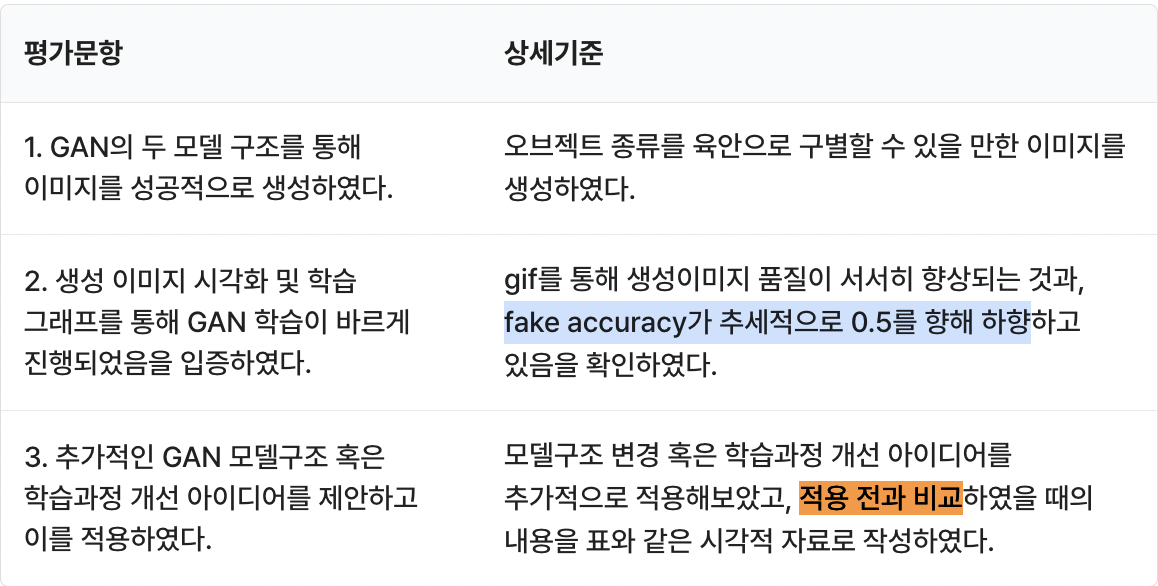

# STEP 1. 작업환경 구성하기

In [7]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
ls ~/aiffel/dcgan_newimage/cifar10

generated_samples/  training_checkpoints/  training_history/


# STEP 2. 데이터셋 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
### 참조만 하라는 코드
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

#####################################################################

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
train_x.shape, test_x.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

train_x[0].min() # 0  
train_x[0].max() # 255  
type(train_x) # numpy.ndarray  

In [3]:
train_x = train_x.astype("float32")
# (255 / 127.5) -1 이런 방법도 있더라
train_x = (train_x - (255 / 2)) / (255 / 2)

tr_x[0].min() # -1.0  
tr_x[0].max() # 1.0

In [18]:
# tr_x = tr_x.reshape(tr_x.shape[0], 32, 32, 3).astype("float32")

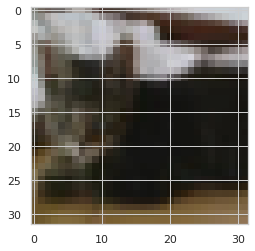

In [22]:
plt.imshow((tr_x[9] +1) /2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


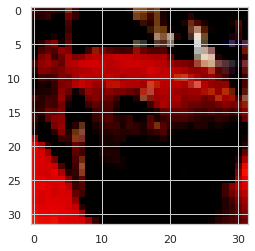

In [23]:
plt.imshow(tr_x[5].reshape(32, 32, 3));

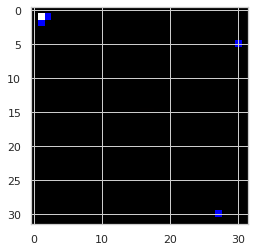

In [16]:
plt.imshow(tr_x[0].astype('uint8'));
# https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa

In [4]:
tr_x.shape[0]

50000

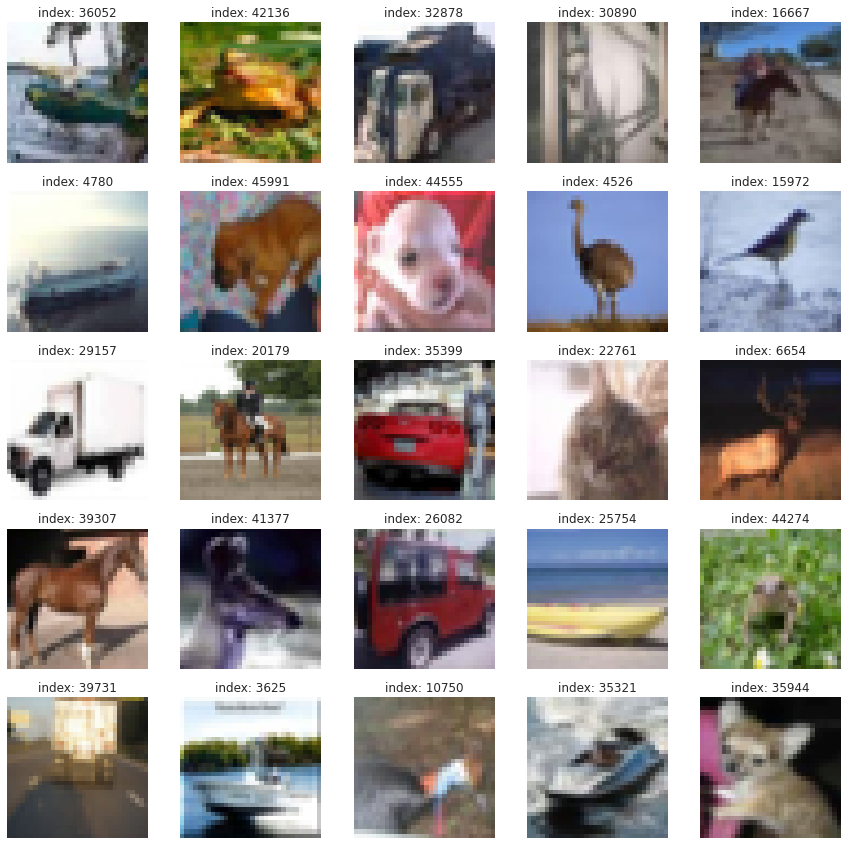

In [10]:
plt.figure(figsize=(15, 15)) # 전체 프레임의 크기를 결정

for i in range(25):
    plt.subplot(5, 5, i+1)
    r = np.random.randint(0, train_x.shape[0])
    plt.imshow((train_x[r] +1) / 2)
    plt.title(f'index: {r}')
    plt.axis('off')
plt.show()

오... 카와이이한거 좀 나왔으니까 다음으로!

In [4]:
BUFFER_SIZE = train_x.shape[0] # 50,000
BATCH_SIZE = 2 ** 10 # 1024

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).\
                shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>

# STEP 3. 생성자 모델 구현하기
1. (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성
2. noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여  
    방금 구현한 생성자로 랜덤 이미지를 생성
3. 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [6]:
img_shape = (100,)
unit = 512 * 8 * 8 # 32768

`ValueError: total size of new array must be unchanged`  
input_shape[32, 32, 16384], output_shape = [8, 8, 256]  
->>> img_shape = (32, 32, 3)  --->  (100,)

In [7]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(units= unit, use_bias=False, input_shape=img_shape))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))

    # 4th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 5th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 6th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 7th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))

    # 8th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 9th: Conv2DTranspose layer
#     model.add(layers.Dropout(.5))
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             3276800   
_________________________________________________________________
batch_normalization (BatchNo (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         6553600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

generator  
<keras.engine.sequential.Sequential at 0x7f767caaaca0>

In [9]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

1. 7th's stride = 2 -> 1,    
2. 9th's filters = 1 -> 3  

> TensorShape([1, 64, 64, 1]) -> TensorShape([1, 32, 32, 3])

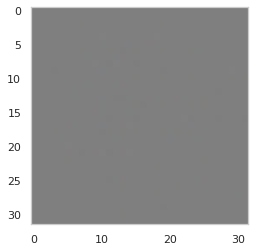

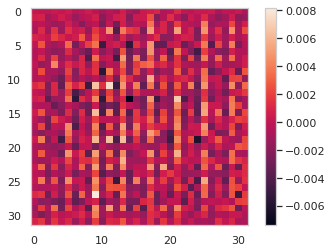

In [90]:
plt.imshow((generated_image[0] +1) / 2 )
plt.grid(b=None);

plt.figure()

plt.imshow(generated_image[0, :, :, 0])
plt.grid(b=None)
plt.colorbar();

# STEP 4. 판별자 모델 구현하기
1. (32, 32, 3)의 이미지를 입력으로 받아  
    1 dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
2. 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인  

In [10]:
img_shape2 = [32, 32, 3]

In [11]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape2))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))

    # 4th: Conv2D Layer
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))
    
    # 5th: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))

    # 6th: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
    model.add(layers.Dropout(0.3))
    
    # 7th: Flatten Layer
    model.add(layers.Flatten())

    # 8th: Dense Layer
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [12]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)        

In [13]:
decision = discriminator(generated_image, training=False)
# <tf.Tensor: shape=(1, 1), dtype=float32, 
# numpy=array([[0.5000001]], dtype=float32)>

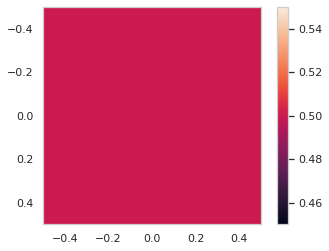

In [20]:
plt.imshow(decision)
plt.grid(b=None)
plt.colorbar();

# STEP 5. 손실함수와 최적화 함수 구현하기
1. 생성자와 판별자의 손실함수(loss)를 구현  
2. 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 Accuracy를 계산하는 함수를 구현  
3. 생성자와 판별자를 최적화하는 optimizer를 정의  


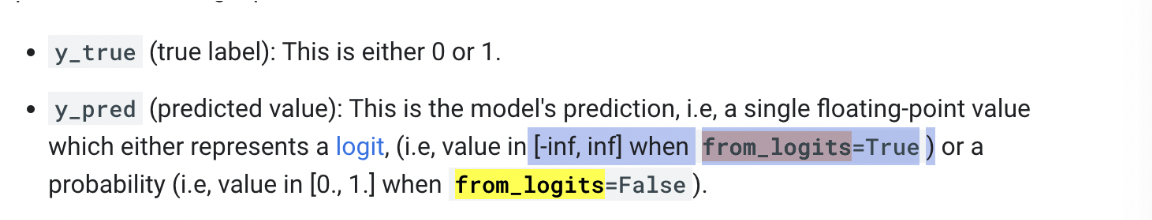

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

discriminator_optimizer = tf.keras.optimizers.Adam(4e-4) # 0.0004

# STEP 6. 훈련과정 상세 기능 구현하기
1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안  
    생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
3. 훈련 epoch마다 생성자/판별자의 loss 및  
    판별자의 실제/생성(real/fake) 이미지 판별 accuracy history를 그래프로 시각화하는 draw_train_history() 함수를 구현  
4. training_checkpoints 디렉토리에  
    몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [17]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
print(seed.shape)
seed

(16, 100)


<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.3952531 , -1.5495926 ,  1.1710942 , ..., -0.9811765 ,
        -0.19928472,  0.3043985 ],
       [ 0.889723  , -1.213115  , -1.4950466 , ...,  0.9640894 ,
         0.5024879 ,  0.2116391 ],
       [-0.27285478,  1.5066582 , -0.8810427 , ...,  0.5351731 ,
        -0.87764806,  0.03859128],
       ...,
       [ 0.66135526,  1.0583774 ,  0.90871716, ..., -0.69792783,
        -0.9479209 , -0.6885312 ],
       [-0.9467906 , -0.48585054, -0.9710834 , ..., -1.253348  ,
        -0.5053932 ,  0.04004595],
       [ 0.07774547,  0.43960685,  1.1524893 , ..., -1.8943168 ,
         0.08750111,  0.8669204 ]], dtype=float32)>

In [18]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, 
                                       fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, 
                                                              fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [19]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow((predictions[i] +1) / 2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it)) # it 매개변수

    plt.show()

In [30]:
ls ~/aiffel/dcgan_newimage/cifar10  

generated_samples/  training_checkpoints/  training_history/


In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

ckpt ?= check-point

In [21]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기
1. 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행
2. 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현
3. 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

> (참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나,  
학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다.  
그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.

> 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다.  
이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있다.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [22]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss,\
            real_accuracy, fake_accuracy = train_step(image_batch)
            
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, 
                                         epoch +1, it +1, seed)
                print('Epoch {} | iter {}'.format(epoch +1, it +1))
                print('Time for epoch {} : {} sec'.format(epoch +1, 
                                                          int(time.time() -epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() -start)))

        draw_train_history(history, epoch)

In [37]:
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
save_every = 5
EPOCHS = 555 # 55555 -> 928 h

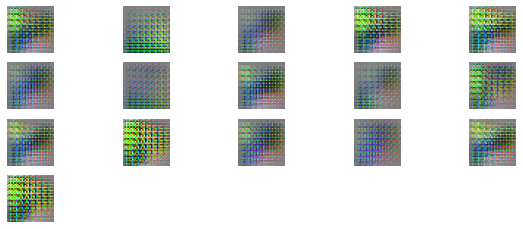

Epoch 297 | iter 1
Time for epoch 297 : 4 sec


KeyboardInterrupt: 

In [25]:
%%time
train(train_dataset, EPOCHS, save_every)

In [26]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [27]:
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1465368 Mar  3 02:12 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


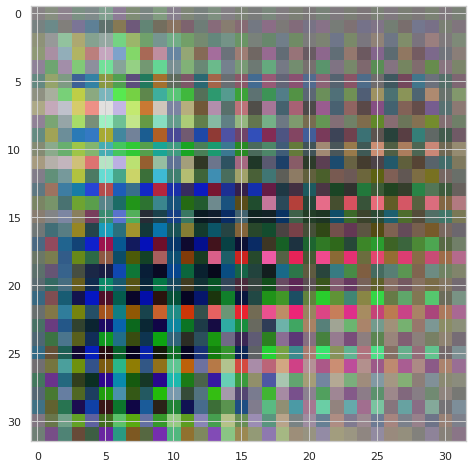

In [28]:
# checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

피카소가 보여요

---

---

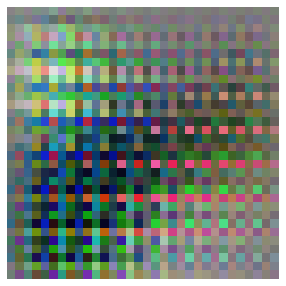

In [32]:
plt.figure(figsize=(5,5))
plt.imshow(np_generated[0])
plt.grid(b=None)
plt.axis("off");

---

In [33]:
img_shape = (128,)
unit = 128 * 8 * 8 # 32768

`ValueError: total size of new array must be unchanged`  
input_shape[32, 32, 16384], output_shape = [8, 8, 256]  
->>> img_shape = (32, 32, 3)  --->  (100,)

In [34]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(units= unit, use_bias=False, input_shape=img_shape))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.LeakyReLU(alpha=.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, 
                                     padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))

    # 4th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, 
                                     padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 5th: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, 
                                     padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2))
    
    # 6th: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
#                                      padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.LeakyReLU(alpha=.2))
    
#     # 7th: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), 
#                                      padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.LeakyReLU(alpha=.2))

#     # 8th: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), 
#                                      padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum=0.8))
#     model.add(layers.LeakyReLU(alpha=.2))
    
    # 9th: Conv2DTranspose layer
#     model.add(layers.Dropout(.5))
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, 
                                     padding='same', use_bias=False, \
                                     activation='sigmoid'))

    return model

In [35]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              1048576   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 16, 16, 128)       262144    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 32, 32, 256)       524288    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 64, 64, 512)      

generator  
<keras.engine.sequential.Sequential at 0x7f767caaaca0>

In [9]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

# STEP 4. 판별자 모델 구현하기
1. (32, 32, 3)의 이미지를 입력으로 받아  
    1 dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
2. 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인  

In [36]:
img_shape2 = [64, 64, 3]

In [48]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape2))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))

    # 4th: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))
    
    # 5th: Conv2D Layer
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))

    # 6th: Conv2D Layer
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
#     model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=.2)) ###
#     model.add(layers.Dropout(0.3))
    
    # 7th: Flatten Layer
    model.add(layers.Flatten())

    # 8th: Dense Layer
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [49]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 8, 8, 128)        

In [41]:
generated_image.shape

TensorShape([1, 32, 32, 3])

In [50]:
decision = discriminator(generated_image, training=False)

# STEP 5. 손실함수와 최적화 함수 구현하기
1. 생성자와 판별자의 손실함수(loss)를 구현  
2. 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 Accuracy를 계산하는 함수를 구현  
3. 생성자와 판별자를 최적화하는 optimizer를 정의  


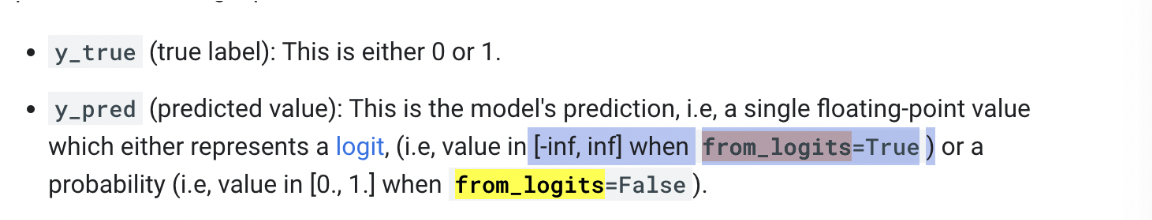

In [51]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [52]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0001

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # 0.0004

# STEP 6. 훈련과정 상세 기능 구현하기
1. 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현
2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안  
    생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현
3. 훈련 epoch마다 생성자/판별자의 loss 및  
    판별자의 실제/생성(real/fake) 이미지 판별 accuracy history를 그래프로 시각화하는 draw_train_history() 함수를 구현  
4. training_checkpoints 디렉토리에  
    몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정

In [54]:
noise_dim = 128
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 128])

In [55]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, 
                                       fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, 
                                                              fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [61]:
# mkdir -p ~/aiffel/dcgan_newimage/cifar101/generated_samples
# mkdir -p ~/aiffel/dcgan_newimage/cifar101/training_checkpoints
# mkdir -p ~/aiffel/dcgan_newimage/cifar101/training_history
# ls ~/aiffel/dcgan_newimage/cifar101

generated_samples/  training_checkpoints/  training_history/


In [62]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(10, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow((predictions[i] +1) / 2)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar101/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it)) # it 매개변수

    plt.show()

In [63]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar101/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [64]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar101/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [65]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss,\
            real_accuracy, fake_accuracy = train_step(image_batch)
            
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, 
                                         epoch +1, it +1, seed)
                print('Epoch {} | iter {}'.format(epoch +1, it +1))
                print('Time for epoch {} : {} sec'.format(epoch +1, 
                                                          int(time.time() -epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() -start)))

        draw_train_history(history, epoch)

In [66]:
save_every = 5
EPOCHS = 55 # 55555 -> 928 h

In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,512,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/conv2d_transpose_9/conv2d_transpose (defined at /tmp/ipykernel_31/2965998720.py:6) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_step_318049]

Function call stack:
train_step


# 회고

1. cifar10 dataset 불러온다.  
2. (-1) ~ 1의 값을 가질 수 있도록 정규화 작업 시이자악  


GAN = Generator + discriminator

의욕이 사라졌다.

# 참조

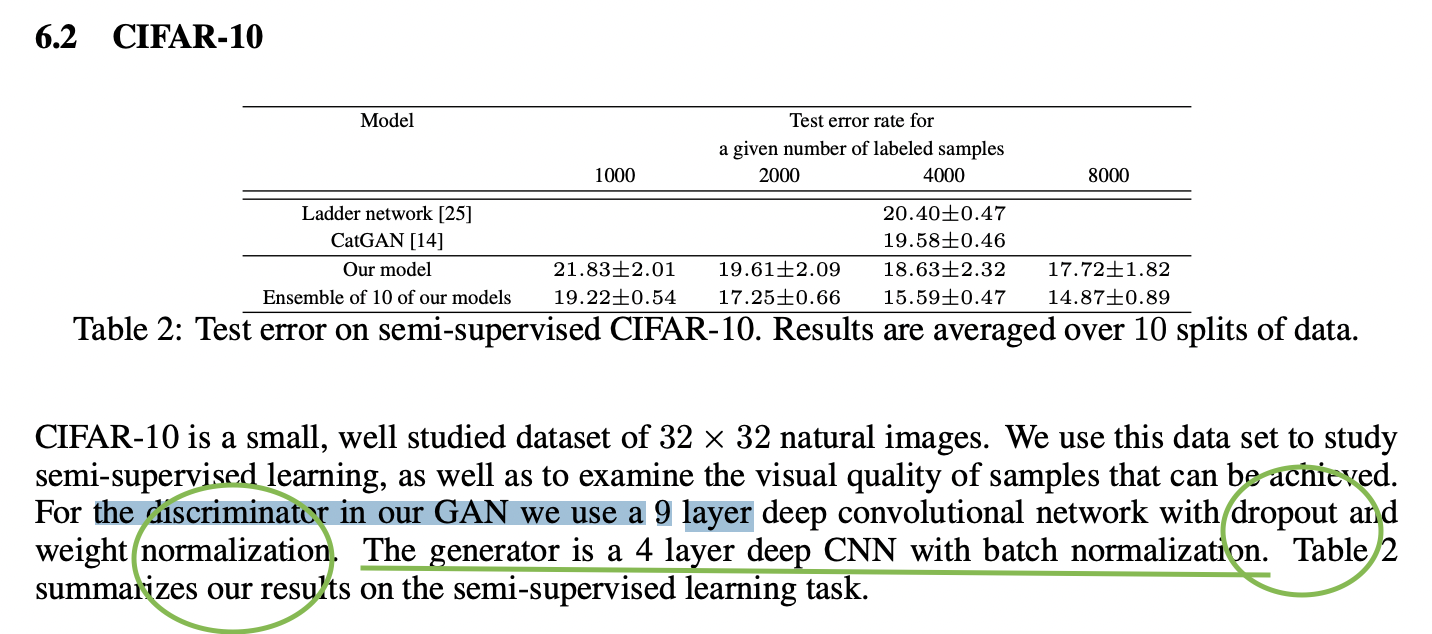

1. lower learning rate
> I often choose 0.0004 for the discriminator   
> 0.0001 for the generator

2. Adding Noise
3. if the label set for real images is 1, we change it to a lower value, like 0.9

4. Balancing Generator and Discriminator weight updates

---
https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf  
https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

1. EXP =? Expression
2. GAN = generative adversarial network
3. SN = spectral normalization 
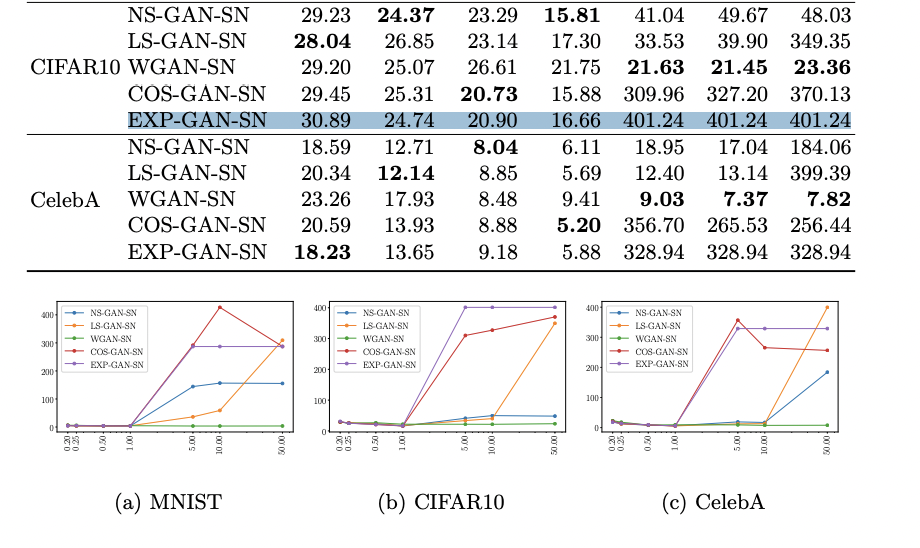
---
https://arxiv.org/pdf/1811.09567.pdf  
https://github.com/kakaobrain/expgan

P.S 사요나라